In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
df = pd.read_csv('heart_rate.csv')
df.head()

,T1,T2,T3,T4
0,84.2697,91.4634,60.4839,59.2885
1,84.2697,91.4634,60.4839,59.2885
2,84.0619,91.1834,60.4606,59.2885
3,85.6542,91.8788,60.3391,58.8973
4,87.2093,91.1772,60.0762,58.4359


In [4]:
df

,T1,T2,T3,T4
0,84.2697,91.4634,60.4839,59.2885
1,84.2697,91.4634,60.4839,59.2885
2,84.0619,91.1834,60.4606,59.2885
3,85.6542,91.8788,60.3391,58.8973
4,87.2093,91.1772,60.0762,58.4359
...,...,...,...,...
1795,103.7900,98.6842,NaN,NaN
1796,101.6230,98.6842,NaN,NaN
1797,99.5679,99.0005,NaN,NaN
1798,99.1835,99.3273,NaN,NaN


ADF Statistic: -4.834806010631323
p-value: 4.663358006880106e-05
Critical Values:
    1%: -3.4377022625762232 - Data is stationary
    5%: -2.8647856243940817 - Data is stationary
    10%: -2.568498194061815 - Data is stationary


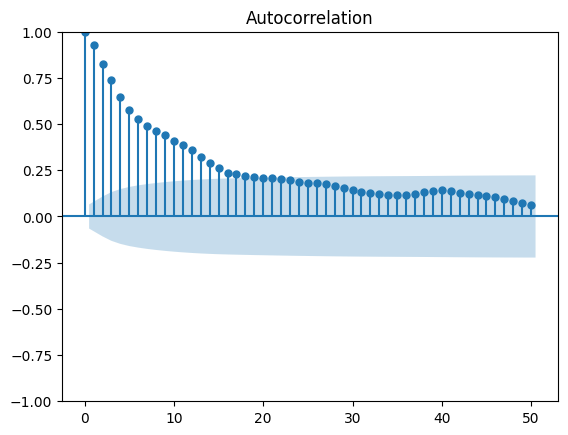

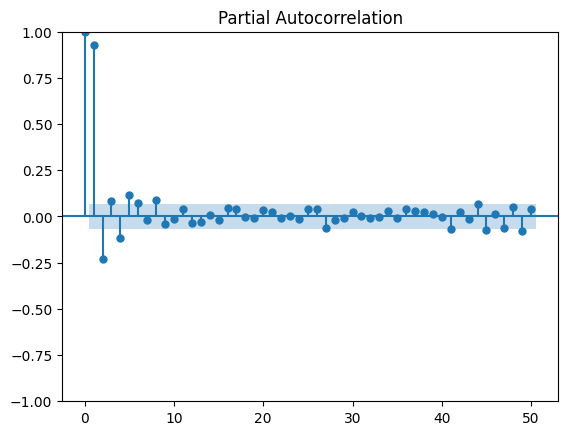

d:\miniconda\envs\mlops\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



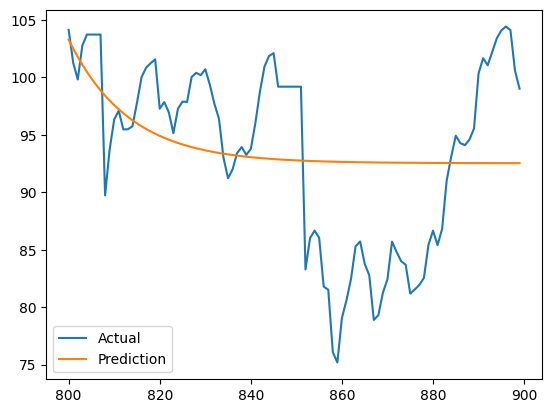

RMSE: 7.299406529109165


d:\miniconda\envs\mlops\lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning:

Error fitting  ARIMA(0,0,1)(2,0,0)[2] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "d:\miniconda\envs\mlops\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "d:\miniconda\envs\mlops\lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "d:\miniconda\envs\mlops\lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "d:\miniconda\envs\mlops\lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "d:\miniconda\envs\mlops\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 704, in fit
    mlefit = super(MLEModel, self).fit(start_params, method=method,
  File "d:\minicon

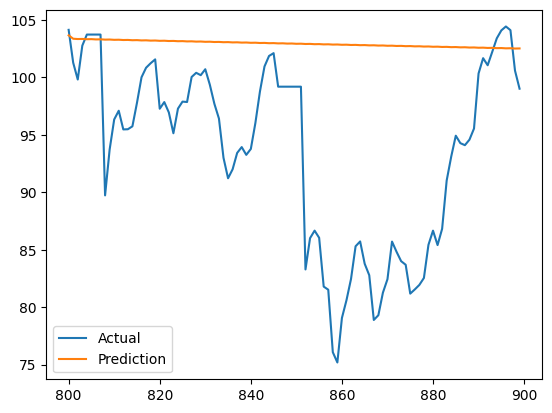

RMSE: 12.272878651484277


In [21]:
# df terdiri dari 4 kolom yaitu T1, T2, T3, T4 semua adalah hasil pengukuran PPG
# Setiap data adalah hasil pengukuran sinyal PPG selama 0.5 detik
# Kebutuhan data adalah 1 detik
# Jadi kita akan menggabungkan 2 data PPG T1 menjadi 1 data PPG dengan cara mengambil rata-rata dari 2 data tersebut
# Misal di kolom T1, ambil 2 baris pertama dan kedua dijadikan 1 baris kemudian ambil rata-ratanya

df_second = df.copy()
for i in range(0, len(df_second), 2):
    df_second.loc[i] = df_second.loc[i:i+1].mean()

df_second = df_second.drop(df_second.index[1::2])
df_second = df_second.reset_index(drop=True)
df_second

# Plot data PPG hasil penggabungan dengan plotly
fig = px.line(df_second['T1'], title='PPG Signal', labels={'index':'Time (s)', 'value':'PPG Signal'})
fig.show()

# Total data df_second adalah 900 data/detik = 15 menit
# Kita akan melakukan pemodelan data PPG dengan menggunakan model ARIMA
# Sebelumnya kita akan mengecek apakah data stasioner atau tidak
# Kita akan menggunakan Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        if result[0] > value:
            print(f'    {key}: {value} - Data is not stationary')
        else:
            print(f'    {key}: {value} - Data is stationary')

adf_test(df_second['T1'])

# Dari hasil Augmented Dickey-Fuller Test, data PPG stationer
# Kita akan melakukan pemodelan data PPG dengan ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

# Plot ACF dan PACF
plot_acf(df_second['T1'], lags=50)
plt.show()

plot_pacf(df_second['T1'], lags=50)
plt.show()

# Dari plot ACF dan PACF, kita akan menggunakan ARIMA(1,0,0)
# Kita akan membagi data menjadi data training dan data testing
train = df_second['T1'][:800]
test = df_second['T1'][800:]

# Membuat model ARIMA
model = ARIMA(train, order=(1,0,0))
model_fit = model.fit()
model_fit.summary()

# Prediksi data testing
start = len(train)
end = len(train) + len(test) - 1
pred = model_fit.predict(start=start, end=end, typ='levels')

# Plot hasil prediksi
plt.plot(test, label='Actual')
plt.plot(pred, label='Prediction')
plt.legend()
plt.show()

# Menghitung nilai RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test, pred))
print(f'RMSE: {rmse}')

# Dari hasil prediksi, RMSE yang didapat adalah 7.299406529109165
# Nilai RMSE yang didapat cukup tinggi, kita akan mencoba menggunakan model SARIMA
# Kita akan mencari nilai p, d, dan q yang optimal
# Kita akan menggunakan Auto ARIMA
from pmdarima import auto_arima

auto_model = auto_arima(train, seasonal=True, m=2)
auto_model.summary()

# Dari hasil Auto ARIMA, model SARIMAX(0, 0, 1)x(1, 0, 1, 2) adalah model yang optimal
# Kita akan membuat model SARIMAX
model_sarima = SARIMAX(train, order=(0,0,1), seasonal_order=(1,0,1,2))
model_sarima_fit = model_sarima.fit()
model_sarima_fit.summary()

# Prediksi data testing
pred_sarima = model_sarima_fit.predict(start=start, end=end, typ='levels')

# Plot hasil prediksi
plt.plot(test, label='Actual')
plt.plot(pred_sarima, label='Prediction')
plt.legend()
plt.show()

# Menghitung nilai RMSE
rmse_sarima = np.sqrt(mean_squared_error(test, pred_sarima))
print(f'RMSE: {rmse_sarima}')

# Dari hasil prediksi, RMSE yang didapat adalah 12.272878651484277
# Nilai RMSE yang didapat cukup tinggi, kita akan mencoba menggunakan model lain yaitu LSTM
# Kita akan menggunakan LSTM untuk memodelkan data PPG
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import numpy as np

# Normalisasi data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))

# Membuat data training dengan timestep 60
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data)-time_step):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_scaled, time_step)

# Reshape data untuk LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Membuat model LSTM
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Latih model
model_lstm.fit(X_train, y_train, epochs=10, batch_size=1)

# Membuat data testing
test_scaled = scaler.transform(test.values.reshape(-1, 1))
X_test, y_test = create_dataset(test_scaled, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Prediksi data testing
pred_lstm = model_lstm.predict(X_test)
pred_lstm = scaler.inverse_transform(pred_lstm)

# Plot hasil prediksi
plt.plot(test[time_step:], label='Actual')
plt.plot(pred_lstm, label='Prediction')
plt.legend()
plt.show()

# Menghitung nilai RMSE
test_adjusted = test[time_step:].reset_index(drop=True)
pred_lstm_adjusted = pred_lstm.flatten()
rmse_lstm = np.sqrt(mean_squared_error(test_adjusted, pred_lstm_adjusted))
print(f'RMSE: {rmse_lstm}')

# Dari hasil prediksi, RMSE yang didapat adalah 1.84039287735911
# Nilai RMSE yang didapat cukup rendah, kita akan menggunakan model LSTM sebagai model prediksi data PPG
# Kita akan melakukan peramalan data PPG selama 15 menit kedepan dari data terakhir

last_data = df_second['T1'][-time_step:]
last_data_scaled = scaler.transform(last_data.values.reshape(-1, 1))
X_last_data = last_data_scaled.reshape(1, time_step, 1)



from tqdm import tqdm
last_data = df_second['T1'][-time_step:]
last_data_scaled = scaler.transform(last_data.values.reshape(-1, 1))
X_last_data = last_data_scaled.reshape(1, time_step, 1)

pred_future2 = []
for i in tqdm(range(20)): 
    pred = model_lstm.predict(X_last_data)
    pred_future2.append(pred[0][0])
    last_data_scaled = np.append(last_data_scaled, pred)
    last_data_scaled = last_data_scaled[1:]
    X_last_data = last_data_scaled.reshape(1, time_step, 1)
    if i % 10 == 0:
        # Update train_scaled with new predictions
        train_scaled = np.append(train_scaled, pred.flatten())  # Ensure pred is flattened before appending
        # Reshape train_scaled to 2D before passing to create_dataset
        train_scaled_2d = train_scaled.reshape(-1, 1)  # Reshape to 2D
        X_train, y_train = create_dataset(train_scaled_2d, time_step)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        model_lstm.fit(X_train, y_train, epochs=2, batch_size=1, steps_per_epoch=50)
        
# Inverse transform pred_future
pred_future2 = scaler.inverse_transform(np.array(pred_future2).reshape(-1, 1)).flatten()

# Plot forecast data PPG yang melanjutkan data asli
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_second['T1'], color='blue', label='Data Asli')
sns.lineplot(data=list(df_second['T1']) + list(pred_future2), color='red', label='Forecast Data')
plt.title('Perubahan PPG')
plt.xlabel('Menit')
plt.ylabel('PPG')
plt.show()

